# GAN Project, Working through CycleGans
Prepared by Ryan Birmingham
Data from https://www.kaggle.com/competitions/gan-getting-started/overview/description

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# kaggle input files, autopopulated
! ls /kaggle/input/gan-getting-started/

In [ ]:
! ls /kaggle/input/gan-getting-started/monet_jpg | head

In [ ]:
ls -l /kaggle/input/gan-getting-started/monet_jpg | wc -l

In [2]:
! ls /kaggle/input/gan-getting-started/photo_jpg | head

00068bc07f.jpg
000910d219.jpg
000ded5c41.jpg
00104fd531.jpg
001158d595.jpg
0033c5f971.jpg
0039ebb598.jpg
003aab6fdd.jpg
003c6c30e0.jpg
00479e2a21.jpg
ls: write error: Broken pipe


In [3]:
ls -l /kaggle/input/gan-getting-started/photo_jpg | wc -l

7039


In [4]:
import os
from PIL import Image


monet_dir = '/kaggle/input/gan-getting-started/monet_jpg'
photo_dir = '/kaggle/input/gan-getting-started/photo_jpg'

monet_sizes = []
photo_sizes = []

for filename in os.scandir(monet_dir):
    if filename.is_file():
        with Image.open(filename.path) as img:
            monet_sizes.append(img.size)
            
for filename in os.scandir(photo_dir):
    if filename.is_file():
        with Image.open(filename.path) as img:
            photo_sizes.append(img.size)

showing /kaggle/input/gan-getting-started/monet_jpg/a642e9cb6f.jpg


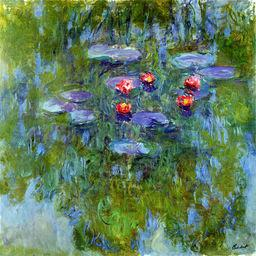

showing /kaggle/input/gan-getting-started/monet_jpg/c78b4fa3a9.jpg


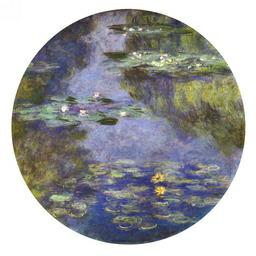

showing /kaggle/input/gan-getting-started/monet_jpg/e2253b87a0.jpg


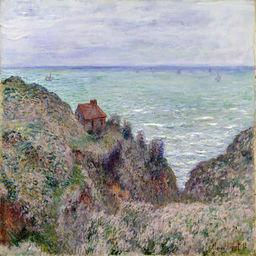

showing /kaggle/input/gan-getting-started/monet_jpg/dcab49d080.jpg


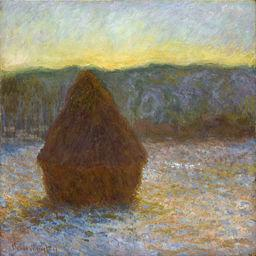

showing /kaggle/input/gan-getting-started/monet_jpg/8044a92484.jpg


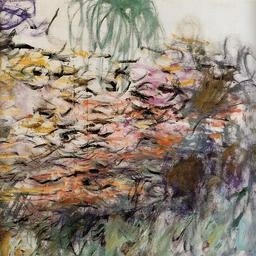

showing /kaggle/input/gan-getting-started/monet_jpg/a030bc32e6.jpg


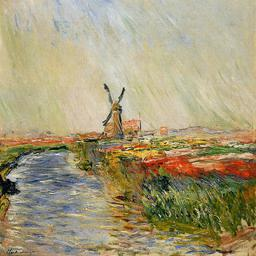

In [5]:
import random
from IPython.display import Image

for filename in os.scandir(monet_dir):
    if filename.is_file():
        if random.random() > 0.98:
            print("showing", filename.path)
            display(Image(filename=filename.path))

showing /kaggle/input/gan-getting-started/photo_jpg/1285f93747.jpg


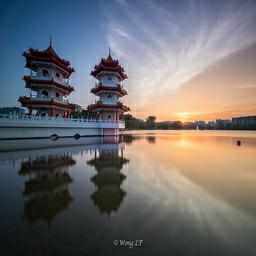

showing /kaggle/input/gan-getting-started/photo_jpg/4707b03a08.jpg


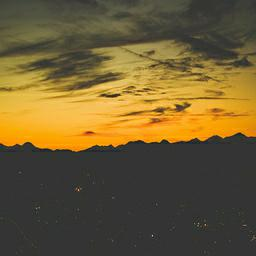

showing /kaggle/input/gan-getting-started/photo_jpg/2ecf4e49d6.jpg


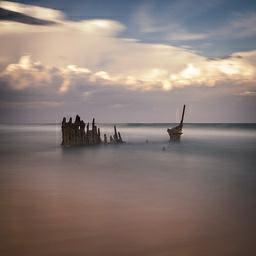

showing /kaggle/input/gan-getting-started/photo_jpg/f74cdcd632.jpg


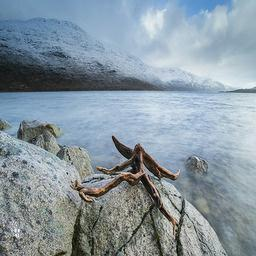

showing /kaggle/input/gan-getting-started/photo_jpg/6ba72ca483.jpg


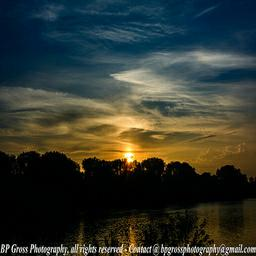

showing /kaggle/input/gan-getting-started/photo_jpg/35e7c9ec58.jpg


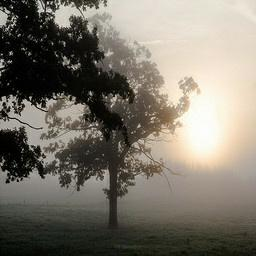

In [6]:
for filename in os.scandir(photo_dir):
    if filename.is_file():
        if random.random() > 0.999:
            print("showing", filename.path)
            display(Image(filename=filename.path))

# Data as Inputs
We know the images are 256x256, and jpg. Let's make a keras dataset out of them.

In [7]:
import tensorflow as tf
monet_data = tf.keras.utils.image_dataset_from_directory(monet_dir, label_mode=None, image_size=(256, 256), batch_size=32)
photo_data = tf.keras.utils.image_dataset_from_directory(photo_dir, label_mode=None, image_size=(256, 256), batch_size=32)
# normalize and resize
monet_data = monet_data.map(lambda x: x / 255.0)
monet_data = monet_data.map(lambda img: tf.keras.preprocessing.image.smart_resize(img, (64,64)))

photo_data = photo_data.map(lambda x: x / 255.0)
photo_data = photo_data.map(lambda img: tf.keras.preprocessing.image.smart_resize(img, (64,64)))

Found 300 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.


In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tfds.disable_progress_bar()
autotune = tf.data.AUTOTUNE

In [10]:
# boilerplate from the keras docs, https://keras.io/examples/generative/cyclegan/


# Define the standard image size.
orig_img_size = (64, 64)
# Size of the random crops to be used during training.
input_img_size = (64, 64, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img


class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

In [11]:
# adapted from keras cycle gan docs at https://keras.io/examples/generative/cyclegan/
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

In [12]:
# adapted from keras cycle gan docs at https://keras.io/examples/generative/cyclegan/
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


In [14]:
# adapted from keras cycle gan docs at https://keras.io/examples/generative/cyclegan/
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Horse and y is zebra
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_y = self.gen_G(real_x, training=True)
            fake_x = self.gen_F(real_y, training=True)
            cycled_x = self.gen_F(fake_y, training=True)
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "G_loss": total_loss_G,
            "F_loss": total_loss_F,
            "D_X_loss": disc_X_loss,
            "D_Y_loss": disc_Y_loss,
        }

In [18]:
# adapted from keras docs at https://keras.io/examples/generative/cyclegan/
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(12, 12))
        for i, img in enumerate(photo_data.take(self.num_img)):
            prediction = self.model.gen_G(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

            prediction = keras.preprocessing.image.array_to_img(prediction)
            prediction.save(
                "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
            )
        plt.show()
        plt.close()

Epoch 1/10
10/10 [==============================] - ETA: 0s - G_loss: 4.9438 - F_loss: 6.3651 - D_X_loss: 0.2594 - D_Y_loss: 0.2642 

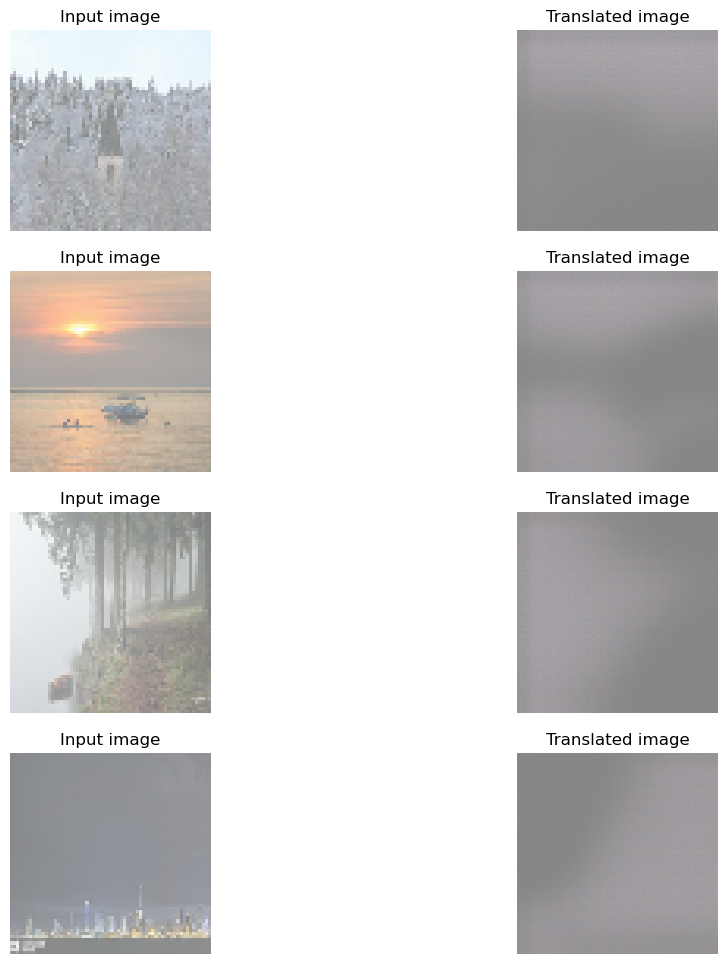

10/10 [==============================] - 528s 46s/step - G_loss: 4.9175 - F_loss: 6.2696 - D_X_loss: 0.2562 - D_Y_loss: 0.2615
Epoch 2/10
10/10 [==============================] - ETA: 0s - G_loss: 3.8508 - F_loss: 4.8256 - D_X_loss: 0.2086 - D_Y_loss: 0.2062 

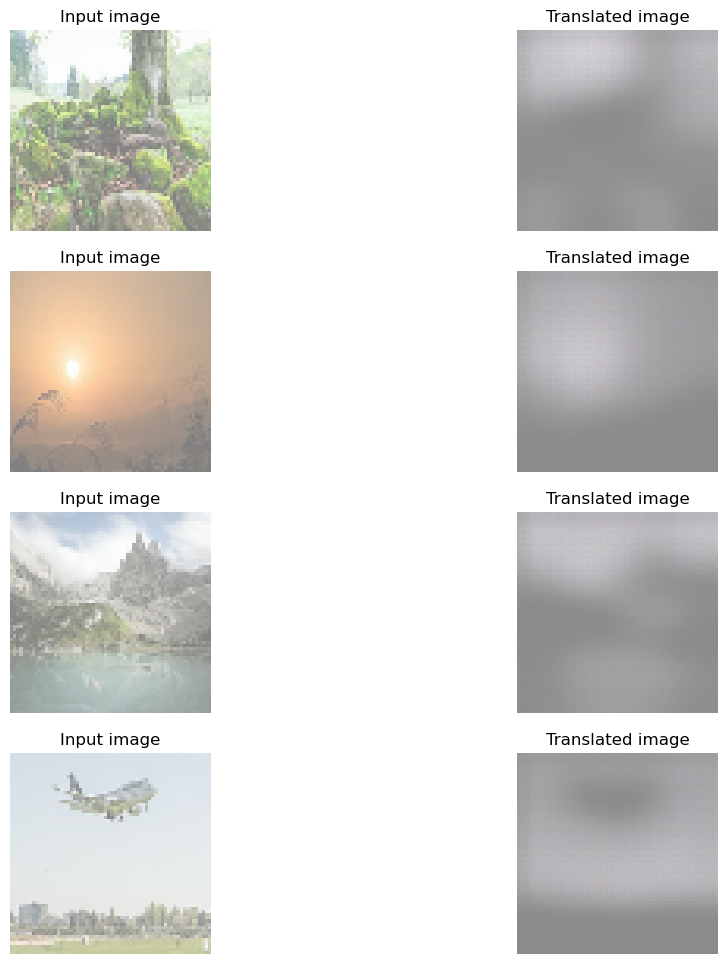

10/10 [==============================] - 458s 46s/step - G_loss: 3.8100 - F_loss: 4.7837 - D_X_loss: 0.2076 - D_Y_loss: 0.2049
Epoch 3/10
10/10 [==============================] - ETA: 0s - G_loss: 3.0935 - F_loss: 3.3651 - D_X_loss: 0.1787 - D_Y_loss: 0.1710 

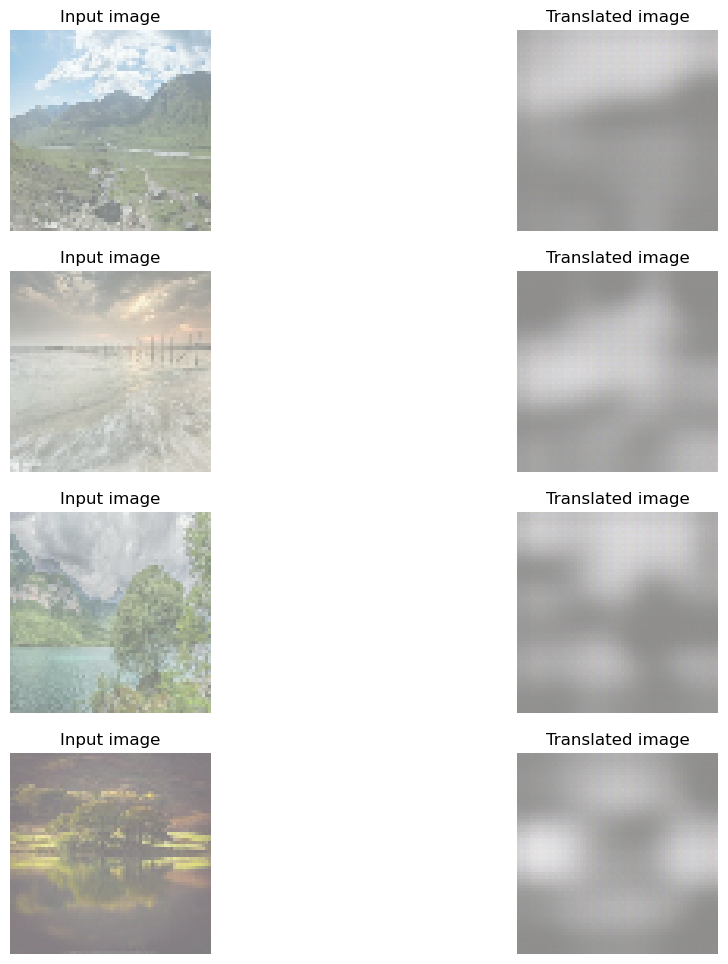

10/10 [==============================] - 456s 46s/step - G_loss: 3.0800 - F_loss: 3.3089 - D_X_loss: 0.1794 - D_Y_loss: 0.1704
Epoch 4/10
10/10 [==============================] - ETA: 0s - G_loss: 3.0074 - F_loss: 2.7573 - D_X_loss: 0.1617 - D_Y_loss: 0.1310 

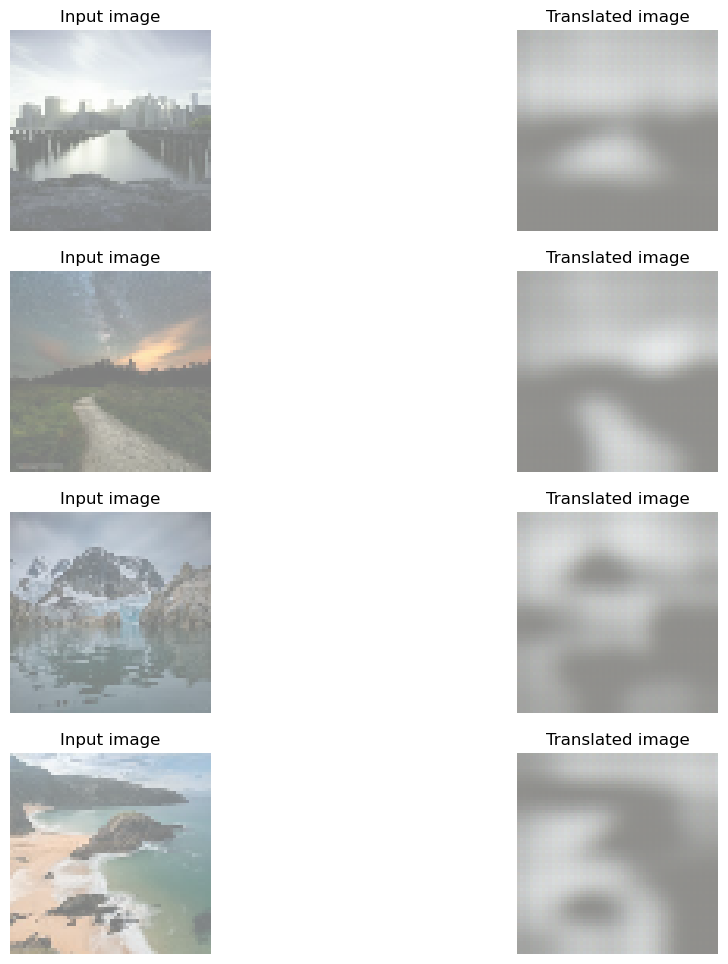

10/10 [==============================] - 456s 45s/step - G_loss: 2.9825 - F_loss: 2.7561 - D_X_loss: 0.1564 - D_Y_loss: 0.1345
Epoch 5/10
10/10 [==============================] - ETA: 0s - G_loss: 2.9611 - F_loss: 2.6061 - D_X_loss: 0.1507 - D_Y_loss: 0.1026 

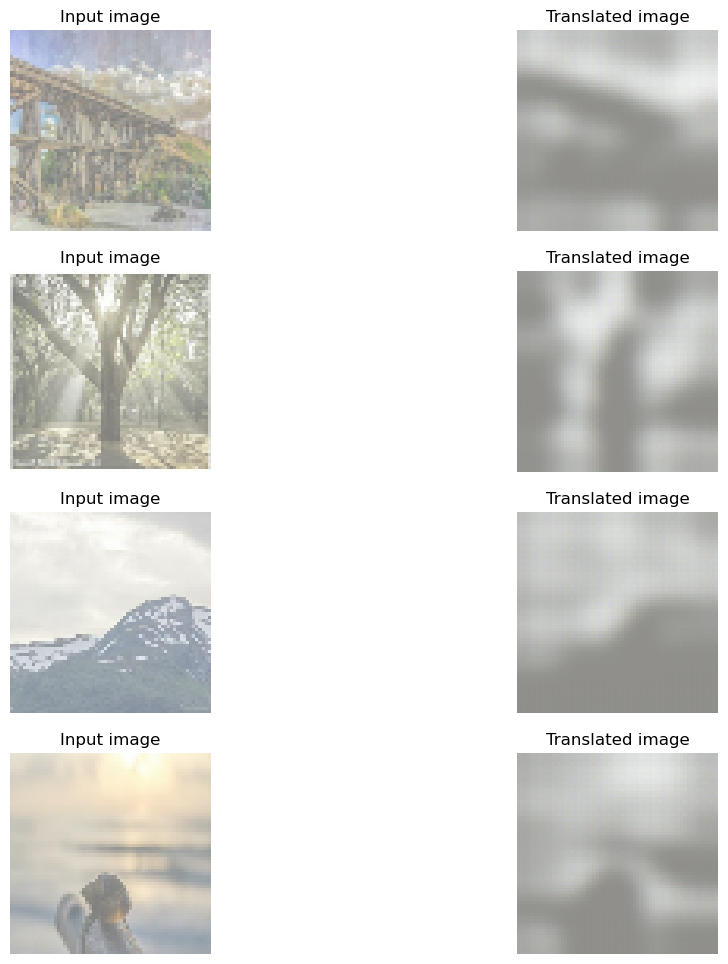

10/10 [==============================] - 456s 45s/step - G_loss: 2.9464 - F_loss: 2.5979 - D_X_loss: 0.1463 - D_Y_loss: 0.1038
Epoch 6/10
10/10 [==============================] - ETA: 0s - G_loss: 2.9250 - F_loss: 2.6654 - D_X_loss: 0.0944 - D_Y_loss: 0.0864 

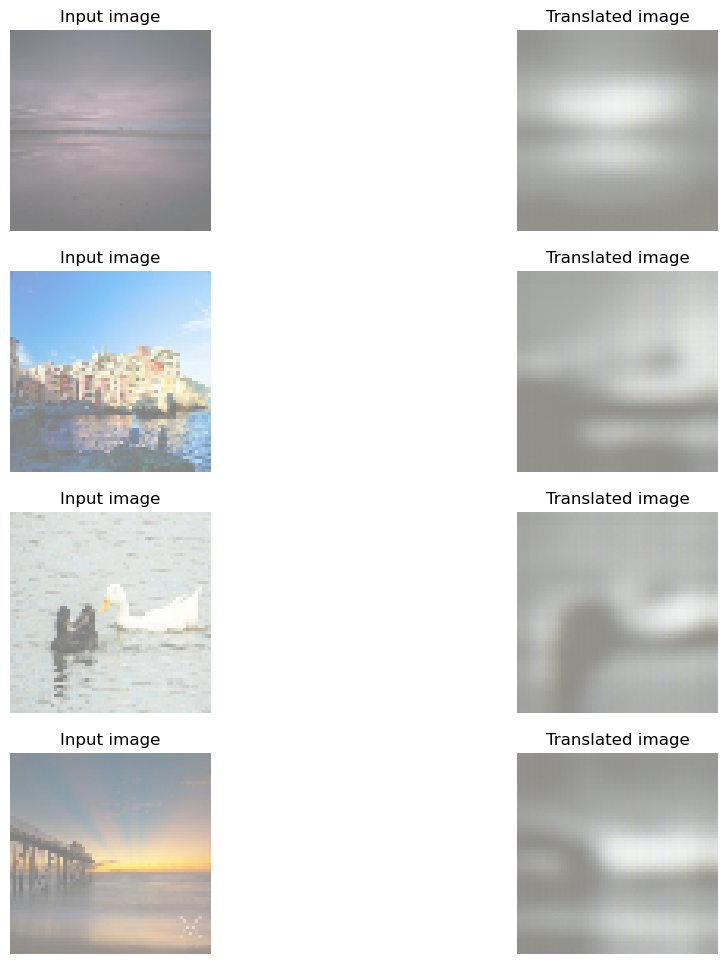

10/10 [==============================] - 460s 46s/step - G_loss: 2.9362 - F_loss: 2.6764 - D_X_loss: 0.0958 - D_Y_loss: 0.0849
Epoch 7/10
10/10 [==============================] - ETA: 0s - G_loss: 2.7813 - F_loss: 2.6387 - D_X_loss: 0.1358 - D_Y_loss: 0.1565 

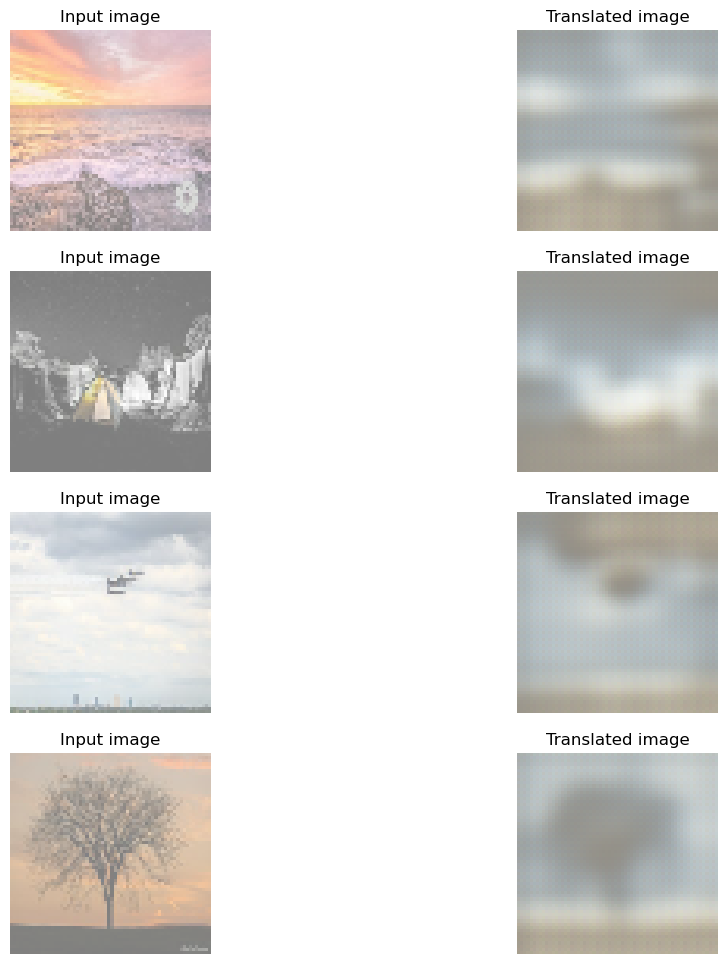

10/10 [==============================] - 456s 46s/step - G_loss: 2.7855 - F_loss: 2.6482 - D_X_loss: 0.1409 - D_Y_loss: 0.1645
Epoch 8/10
10/10 [==============================] - ETA: 0s - G_loss: 2.7978 - F_loss: 2.6007 - D_X_loss: 0.2084 - D_Y_loss: 0.2402 

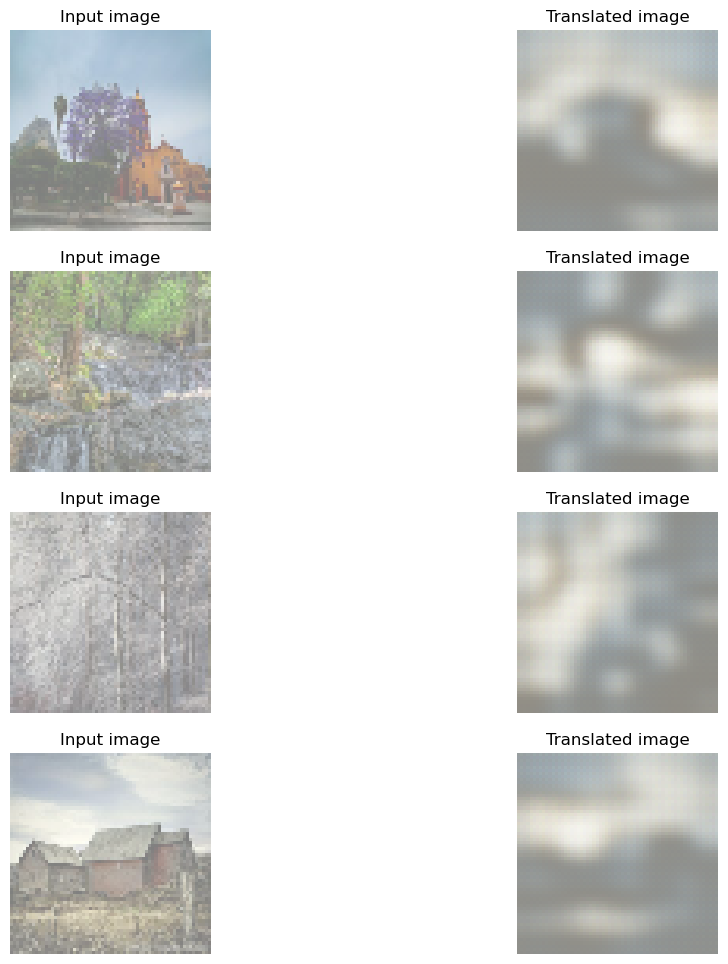

10/10 [==============================] - 457s 46s/step - G_loss: 2.7843 - F_loss: 2.6015 - D_X_loss: 0.2074 - D_Y_loss: 0.2383
Epoch 9/10
10/10 [==============================] - ETA: 0s - G_loss: 2.7021 - F_loss: 2.5513 - D_X_loss: 0.1979 - D_Y_loss: 0.2189 

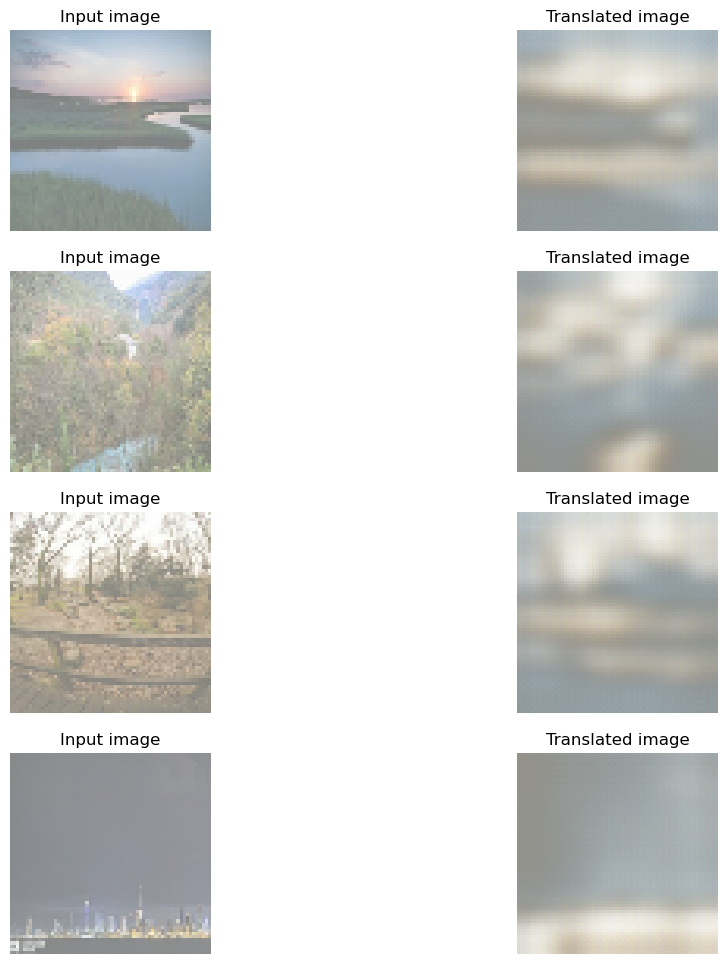

10/10 [==============================] - 457s 46s/step - G_loss: 2.6875 - F_loss: 2.5524 - D_X_loss: 0.1978 - D_Y_loss: 0.2210
Epoch 10/10
10/10 [==============================] - ETA: 0s - G_loss: 2.7609 - F_loss: 2.5784 - D_X_loss: 0.1935 - D_Y_loss: 0.2096 

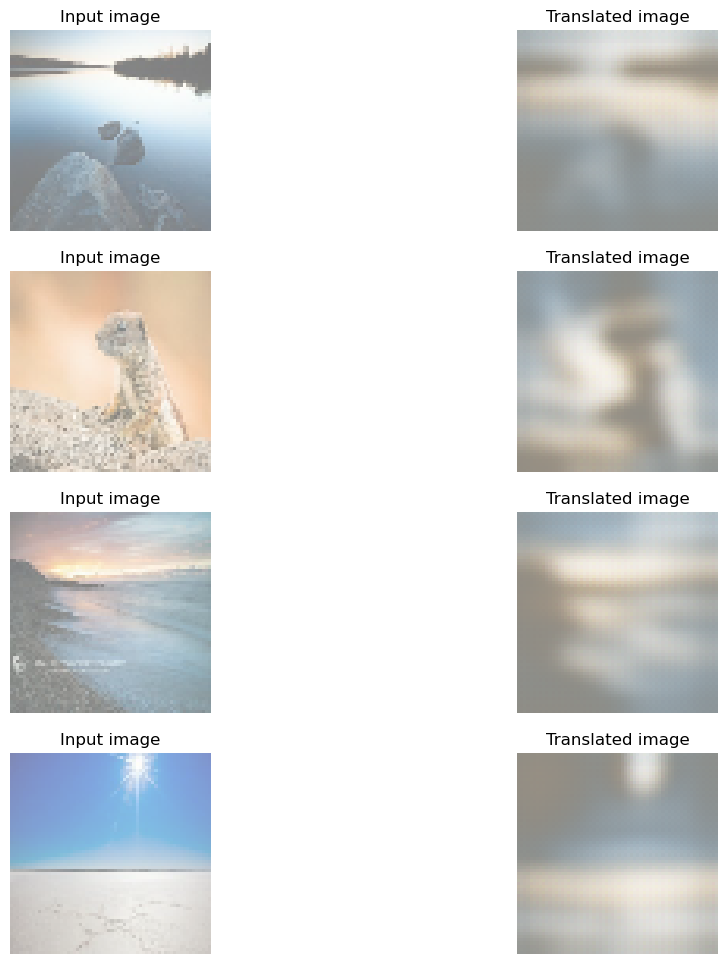

10/10 [==============================] - 462s 46s/step - G_loss: 2.7646 - F_loss: 2.6045 - D_X_loss: 0.1898 - D_Y_loss: 0.2069


In [20]:
# adapted from keras docs at https://keras.io/examples/generative/cyclegan/

# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.legacy.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)
# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "./model_checkpoints/cyclegan_checkpoints.{epoch:03d}"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, save_weights_only=True
)

cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_data, photo_data)),
    epochs=10,
    callbacks=[plotter, model_checkpoint_callback],
)

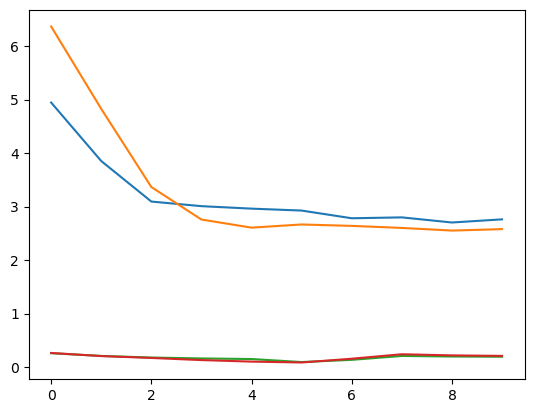

In [27]:
G_losses = [4.9438,3.8508,3.0935,3.0074,2.9611,2.9250,2.7813,2.7978,2.7021,2.7609]
F_losses = [6.3651,4.8256,3.3651,2.7573,2.6061,2.6654,2.6387,2.6007,2.5513,2.5784]
DX_losses = [0.2594,0.2086,0.1787,0.1617,0.1507,0.0944,0.1358,0.2084,0.1979,0.1935]
DY_losses = [0.2642,0.2062,0.1710,0.1310,0.1026,0.0864,0.1565,0.2402,0.2189,0.2096]
plt.plot(G_losses)
plt.plot(F_losses)
plt.plot(DX_losses)
plt.plot(DY_losses)

## Analysis
(un)fortunately, our discriminator is doing much better than our generator on loss (altough this is difficult to compare as they're different metrics and tasks). We do see clear improvement in the generators with epochs, but still no uptick in discriminator. This implies that it may be a lot more training before this becomes complete.

## Discussion and Conclusion
This process has a lot of hyperparameters, and the dataset had relatively few monet images. Nonetheless, we're starting to see some similarities at 10 epochs. However, 10 is clearly not enough, but these take a long time to run. We do see clear improvements from epoch 1 to 10 though, so this is likely okay enough for this minor exploration. It may be interesting to revisit.
## Submission
Prepare some images for submission.

In [23]:
! mkdir output
# generating outputs
def generate(model, epoch, num_img):
    for i, img in enumerate(photo_data.take(num_img)):
        print(i)
        prediction = model.gen_G(img)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        prediction = keras.preprocessing.image.array_to_img(prediction)
        prediction.save(
            "output/generated_img_{epoch}_{i}.png".format(i=i, epoch=epoch + 1)
        )
        
generate(cycle_gan_model, 1, 100)


In [25]:
! zip photos.zip output/*

  adding: output/generated_img_2_0.png (stored 0%)
  adding: output/generated_img_2_1.png (stored 0%)
  adding: output/generated_img_2_10.png (stored 0%)
  adding: output/generated_img_2_11.png (stored 0%)
  adding: output/generated_img_2_12.png (stored 0%)
  adding: output/generated_img_2_13.png (stored 0%)
  adding: output/generated_img_2_14.png (stored 0%)
  adding: output/generated_img_2_15.png (stored 0%)
  adding: output/generated_img_2_16.png (stored 0%)
  adding: output/generated_img_2_17.png (stored 0%)
  adding: output/generated_img_2_18.png (stored 0%)
  adding: output/generated_img_2_19.png (stored 0%)
  adding: output/generated_img_2_2.png (stored 0%)
  adding: output/generated_img_2_20.png (stored 0%)
  adding: output/generated_img_2_21.png (stored 0%)
  adding: output/generated_img_2_22.png (stored 0%)
  adding: output/generated_img_2_23.png (stored 0%)
  adding: output/generated_img_2_24.png (stored 0%)
  adding: output/generated_img_2_25.png (stored 0%)
  adding: outpu